<a id="top"></a>
#  Simulating MIRI MRS Spectroscopy of a Late M Star

#### This notebook simulates the MIRI MRS IFU spectroscopy of a late M star

Details of generating ETC and APT files in this example science program can be found on the JDoX webpages: https://jwst-docs.stsci.edu/mid-infrared-instrument/miri-example-science-programs/miri-mrs-spectroscopy-of-a-late-m-star

These are common stars, so it is important to understand their spectra. Their stellar atmospheres are relatively cool, so they allow for the formation of molecules such as H2O, which give rise to interesting spectra over mid-infrared wavelengths (5–30 microns). 

**In this notebook**, we create a scene of with point sources compised of several spectral types and dust compositions fit within the MRS field of view, and run through a MIRISim simulation showing the products created at each stage.

When launching the notebook, make sure in the right Anaconda environment. i.e. type

<code> source activate miricle </code> 

in the terminal before starting the notebook.

### Steps in this notebook:

0. Import useful python packages
1. Create a Scene
2. Initialise the simulation parameters
3. Run the simulation
4. Examine some of the outputs.  

## Step 0 - Some general python housekeeping
### Import useful python packages

In [1]:
# Import usefull python packages
import numpy as np
import glob                         # glob is used to find the output directory
import os                           # for listing directory contents
from astropy.io import fits,ascii   # for reading FITSand ascii file contents


# Import python packages used to display images inline in the notebook
import matplotlib.pyplot as plt 
from matplotlib import rc
from matplotlib import colors,cm
%matplotlib inline       

######################################
# Now import MIRISim specific packages 

# import the configuration file parsers so they can be written to file
from mirisim.config_parser import SimConfig, SimulatorConfig, SceneConfig

# import scene component generators
from mirisim.skysim import Background, sed, Point, Galaxy, kinetics, ExternalSed
from mirisim.skysim import wrap_pysynphot as wS

from mirisim import MiriSimulation     

In [2]:
### TODO: Remove prior to distibution ###
import logging, sys
logging.disable(sys.maxsize)

### Set flags for saving the MIRISim scene to a fits file - default is False 

In [3]:
save_scene_as_fits = False

### Define some common functions 

1) <code>save_to_fits</code> - Used to save the generated scene to a fits file

2) <code>show_outputs</code> - Used in plotting outputs from MIRISim

3) <code>row_based_idx</code> - Used to fill matplotlib subplots by column, not row

4) <code>show_skycubes_spec</code> - Used to plot the spectrum in datacubes generated by MIRISim

5) <code>create_star_P</code> - Makes a star (point source) instance with an SED corresponding to a model from the library of PHOENIX stellar atmospheres (Husser et al 2013).

In [4]:
def save_to_fits(scene, light_path, filename='MIRISim_scene.fits', SpatialSampling=0.1, WavelengthRange=None, 
                 WavelengthSampling=0.001):
    """
    Function to save the MIRISim scene to a fits file.
    
    :param filename: Name of file to save - default is "MIRISim_scene.fits"
    :type filename: string       
    
    :param SpatialSampling: Spatial sampling (in arcsec) - default is 0.1 arcseconds
    :type SpatialSampling: float
    
    :param WavelengthRange: Wavelength range to process (in microns) - default is [5, 28] microns
    :type WavelengthRange: array
    
    :param WavelengthSampling: Channel width (in microns) - default is 0.001 arcseconds
    :type WavelengthSampling: float
    
    :rtype: None
    :raises Exception: when light_path parameter not set to MRS or IMA
    """
    
    # Avoids array being extended inside function for mutliple calls. Python gotcha
    if WavelengthRange is None:
        WavelengthRange = [5, 28]
        
    if light_path == 'IMA':
        # IMA Field of view [xmin,xmax],[ymin,ymax] [arcsec]
        FOV = np.array([[-57., 57.],[-57., 57.]])   
    elif light_path == "MRS":
        # MRS Field of view [xmin,xmax],[ymin,ymax] [arcsec]
        FOV = np.array([[-4., 4.],[-4., 4.]])       
    else:
        raise Exception('Acceptable inputs for parameter light_path are [IMA] and [MRS]')
    
    # overwrite = True enables overwriting of any previous version of the fits file
    # with the same name as that given in the writecube command
    scene.writecube(cubefits = filename,
                    FOV = FOV, time = 0.0,
                    spatsampling = SpatialSampling,
                    wrange = WavelengthRange,
                    wsampling = WavelengthSampling,
                    overwrite = True) 

In [5]:
def show_outputs(MIRISim_outputdir,output_type):
    """
    Plot the specified channel of the MIRISim outputs
    :param MIRISim_outputdir:  
        name of the date-labelled dir. holding the MIRISIM outputs
    :param output_type: 
        type of output to process 
        (e.g. illum_models, det_images or skycubes)
    """
    
    infits = glob.glob('{}/{}/*.fits'.format(MIRISim_outputdir,output_type))[0]
    
    hdulist = fits.open(infits)
    
    if output_type.lower() == 'skycubes': 
        hdu_index = 0
        datashape = hdulist[hdu_index].data.shape
        central_chan = datashape[0]//2
        
        plt.imshow(hdulist[hdu_index].data[central_chan,:,:],
           origin = 'lower', interpolation = 'nearest',cmap = cm.viridis, aspect='equal')
        plt.title('channel {} of {}'.format(central_chan,infits.split('/')[-1]))
        plt.xlabel(hdulist[hdu_index].header['ctype1'])
        plt.ylabel(hdulist[hdu_index].header['ctype2'])
    else:
        hdu_index = 1
        if len(hdulist[hdu_index].data.shape) > 2:
            integ,frames,nx,ny = hdulist[hdu_index].data.shape
            image = hdulist[hdu_index].data[integ-1,frames-1,:,:]
        else:
            image = hdulist[hdu_index].data
            
        
        plt.imshow(image, origin = 'lower',cmap = cm.viridis,interpolation='nearest', aspect='equal')
        plt.title('{}'.format(infits.split('/')[-1]))
        plt.xlabel('Along Slice Direction')
        plt.ylabel('Wavelength Direction')

    plt.colorbar()

In [6]:
def row_based_idx(num_rows, num_cols, idx):
    """
    Function to fill matplotlib subplots by column, not row
    """
    return np.arange(1, num_rows*num_cols + 1).reshape((num_rows, num_cols)).transpose().flatten()[idx-1]

In [7]:
def show_skycubes_spec(directory_list):
    """
    Plots the average MIRISim spectra for each FOV from the 12 skycubes generated from 
    the Short, Medium and Long dispersers
    :param directory_list:  
        List contaning the three output directories for the MRS simulation results
    """    
    
    # Define subplot grid for the MRS skycubes
    num_cols = 3 
    num_rows = 4             

    maxfigs = 12
    fig = plt.figure(figsize=(10,3*num_rows))
    i=0

    for num, outputdir in enumerate(directory_list):
        outputDirContents = os.listdir(outputdir)

        directories = [name for name in outputDirContents if os.path.isdir(os.path.join(outputdir,name))]

        #print('\nFor the {} the output directory is: {} '.format(sim_filenames[num], outputdir))
        #print('This directory contains four skycubes which cover the wavelength ranges:')

        filenames_skycube = glob.glob('{}/{}/*.fits'.format(outputdir,'skycubes')) # Get skycube file

        for skycube_file in filenames_skycube:

            hdu = fits.open(skycube_file)        # Open file 
            data_cube = hdu[0].data              # Get data 
            #datashape = hdu[0].data.shape       # Get data shape - Z, X, Y  

            # Get the wavelength data 
            wav =  hdu[1].data

            # Find the max and min wavelelgths for the output cube
            vmin = wav[0]
            vmax = wav[-1]       
            #print(np.round(vmin,2), np.round(vmax,2))

            # Get the flux data from an average of the cube
            spectrum = data_cube.mean(axis=(1, 2))  

            # Plot the spectrum - Each colum = short, medium, long
            plt.subplot(num_rows, num_cols, row_based_idx(num_rows, num_cols,i+1))
            plt.plot(wav, spectrum)                                       
            #plt.xticks([])  # help clean up the plot
            plt.yticks([])   # help clean up the plot 
            i+=1    

    fig.add_subplot(111, frame_on=False)

    plt.tick_params(labelcolor="none", bottom=False, left=False)
    plt.xlabel("Wavelength (microns)", fontsize=14)
    plt.ylabel("Flux (data units)", fontsize=14)

    fig.suptitle('    Short                           Medium                           Long', y=1.02, fontsize=18)

    fig.tight_layout()

    plt.show()
    plt.close()    

In [8]:
def create_star_P(xpos, ypos, Temp=3500, FeH=0.0, logg = 4.44, Fl=1e3, wref=10.0):
    """ Makes a star (point source) instance with given initialisation parameters for Phoenix SED

    :param xpos: RA offset from center of scene [arcsec]
    :param ypos: Dec offset from center of scene [arcsec]
    :param Temp: BB temperature = 3500 default [Kelvin]
    :param FeH: Metallicity = 0.1 = solar as default [M/H]
    :param logg: log surface gravity = 4.44 = solar as default [cm/s2]
    :param Fl: Flux to normalise to  = 1e3 default [micro Jy] 
    
    :return: A point source (star) at a specific location initialised with a Phoenix SED
    :rtype: mirisim.skysim.basicsources.Point
    :raises: None
    """    
    star = Point(Cen = (xpos,ypos))        # RA, Dec ofset from center of scene [arcsec]
    pheSED = wS.PYSPSed(family='phoenix', sedpars=[Temp, FeH, logg], flux=Fl, wref=wref)     
    star.set_SED(pheSED)
    
    return star

## Step 1 - Create a Scene - this represents your science observation

Each scene should include at mimumum: 1) A background level; 2) A science source

The scene created below consists of several point sources with spectra representative of late M type stars, both with carbon and oxygen rich dust chemistries that all of which fit within the MRS field of view. The first point source has a Phoenix model atmosphere SED, the other sources have SEDs imported from ISO SWS observations. 

NB ISO SWS spectra were selected over Spitzer IRS data due to the longer wavlength coverage and higher resolution. 

#### Create a low level background for the scene

In [9]:
bg = Background(level='low',gradient=1., pa=45.)

#### Include a cool M-Star with an SED represented by a Phoenix model atmosphere - require a temperature, metalicity and log_g to initialize

In [10]:
# Initialise a single point source at the central position of the MIRI MRS
"""
MIRI MRS FOV     = 3.7 × 3.7  arcseconds  in ALL four channels 
Max MIRI MRS FOV = 7.2 × 7.9  arcseconds  
"""

MRS_radius = 3.2/2.   # Radius of MRS (in arcsec)  

targetlist = []  # For writing to scene.ini file

# Initialize a star with a temprature of 3400K 
star = create_star_P(xpos=0.0, ypos=0.0, Temp=3400)
    
stars = star               # For creating a scene
targetlist.append(star)    # For writing to scene.ini file

#### Add in some dusty AGB stars at random locations using an external SED file

In [11]:
# Ensure the external SED file is in the correct units for MIRISim

file = '63702662.txt'   # original file in microns and Jy need to convert to muJy

data = ascii.read(file)
data['col2'] = data['col2'] * 1e+6
ascii.write(data, '63702662_microJy.txt', overwrite=True)

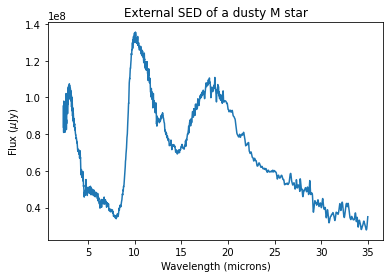

In [12]:
# Get some typical SEDs of a oxygen-rich evolved star. Data from Kraemer et al. (2002) and Sloan et al. (2003)
# Scale the input data outside of MIRISim  if a range of brightness is required. 

# Use: sedfile =  ExternalSed('extsed.txt') # filepath, columns 'wavelength' [microns] and 'flux' [muJy]
av_OAGB_sed = ExternalSed(sedfile = '63702662.txt')
av_OAGB_sed = ExternalSed(sedfile = '63702662_microJy.txt')

# For zooming in on spectral ranges
l_min = 2 #micron
l_max = 35 #micron
sp_min = np.abs(av_OAGB_sed.Lam-l_min).argmin()
sp_max = np.abs(av_OAGB_sed.Lam-l_max).argmin()


# Covert the imput spectrum flux values from muJy to Jy 
#av_OAGB_sed.fLam = av_OAGB_sed.fLam*1e8

# Plot the imported spectrum for refrence - OAGB
fig = plt.figure(figsize=(8, 6))
ax = plt.subplots()[1]  
ax.plot(av_OAGB_sed.Lam[sp_min:sp_max], av_OAGB_sed.fLam[sp_min:sp_max])

ax.set_xlabel("Wavelength (microns)")  
ax.set_ylabel("Flux ($\mu$Jy)")  
ax.set_title("External SED of a dusty M star")  
plt.close(fig)

In [13]:
# To the scene - add in some dusty M-stars  = OAGB
N_mstars = 2         # Number of stars to put within the radius of Imager

for i in range(0,N_mstars):

    # Random placement of N stars 
    xp = np.cos(2*np.pi/N_mstars*i)*np.random.uniform(1,MRS_radius,1)[0]    
    yp = np.sin(2*np.pi/N_mstars*i)*np.random.uniform(1,MRS_radius,1)[0]        
       
    pt_src_OAGB = Point(Cen = (xp,yp))
    pt_src_OAGB.set_SED(av_OAGB_sed)
    
    stars += pt_src_OAGB              # For creating a scene
    targetlist.append(pt_src_OAGB)    # For writing to scene.ini file

### From the components, create a scene

To create a scene adding together the background and targets

In [14]:
scene = bg + stars

### Export the scene to an ini file and FITS file (optional)

Export scene to an ini file (for future use), or a FITS file to be visualised. This stage is not necessary if running mirisim in a notebook.

Exporting to a FITS file requires specifying a number of additional parameters such as the Field of view, required spectral sampling, etc. They're described in more detail below. For large fields of view, and/or small spectral channels, which create large FITS files, writing to a FITS file can take a while (few minutes)


In [15]:
# Used to run MIRISim within notebook
scene_config = SceneConfig.makeScene(loglevel=0,
                                    background=bg,
                                    targets = targetlist)

# Export to FITS file - Optional 
if save_scene_as_fits == True:
    save_to_fits(scene, light_path="MRS", filename='MIRISim_scene.fits')

## Initialise the MRS Simulation Parameters

This is where the parameters for the MRS simulation get set.  These should be set to match the desired MIRI observation setup. 

**Note** MIRISim must have perameters set for all light paths in <code>SimConfig.makeSim</code> this includes some perameters not relevent to the MRS simulation defined in this file. Those perameters not being used in this simulation are labelled with <code> NOT USED HERE </code> in the comments of each line **and should not be deleted**.

###  To get the full 5-28 micron spectral range this simulation uses all three despersers. 

#### In the MRS observation set up select appropriate values for the three despersers to loop the simulation over. 

The following setup assumes that the user is using the full MRS spectral range. 
Parameters to be adjusted based on your desired observation setup are the: 

* sim_filenames
* mrs_exposure_values
* mrs_integration_values
* mrs_frame_values

In [16]:
# Generate a list of three config names for the simulations 
sim_config_list = ['sim_config_s', 'sim_config_m','sim_config_l']

# Set the file names of the three simulations
sim_filenames = ['MRS_short_Mstar_simulation', 'MRS_medium_Mstar_simulation', 'MRS_long_Mstar_simulation']

# Configure the Optical path (MRS sub-band)  
config_path_list = ['MRS_1SHORT', 'MRS_1MEDIUM', 'MRS_1LONG']

# Which disperser to use (SHORT/MEDIUM/LONG) 
disperser_list = ['SHORT', 'MEDIUM', 'LONG']

# Number of MRS exposures 
mrs_exposure_values = [1,1,1]

# Number of MRS integrations
mrs_integration_values = [3,3,3]

# Number of groups (for MIRI, # Groups = # Frames)
mrs_frame_values = [32, 32, 32]

In [17]:
# Now to loop through the three desperser simulation setups 

# Generate combined list of the observation perameters for the three dispersers 
# based on the values imput in the previous cell.
observaton_setup = [
    sim_filenames, config_path_list, disperser_list,
    mrs_exposure_values, mrs_integration_values, mrs_frame_values]

print("SimConfig populated by:")

# Builds a list to contain the sim_obects built in the below loop
sim_objects = list()

# Generates the three simulation objects for the short medium and long and populates 
# the sim_objects list
# Use python zip function to index arrays to minimise potential errors by passing 
# arguments of unequal length 
for (sim_name_el, config_path_list_el, disperser_list_el, 
     mrs_exposer_value_el, mrs_integration_value_el, mrs_frame_values_el) in zip(*observaton_setup):
    
    print ("{} : {} : {} : {} : {} : {}".format(sim_name_el, config_path_list_el,
                                                     disperser_list_el, mrs_exposer_value_el, 
                                                     mrs_integration_value_el, mrs_frame_values_el))
    
    # Add a safety check to make sure each parameter contains values for all the disperser settings. 
    if (len(sim_config_list) != len(sim_filenames) != len(config_path_list) != len(disperser_list) 
        != len(mrs_exposure_values) != len(mrs_integration_values) != len(mrs_frame_values)):
        raise Exception("All three values are not set - Check imputs.")
    
    ############################################################################################
    # This sets up the simulation - adjust values spefific to your observation setup you wish to simulate 
    
    sim_objects.append(SimConfig.makeSim(
        name = sim_name_el,                   # Name given to simulation
        scene = 'MRS_scene.ini',              # Name of scene file to input

        rel_obsdate = 0.0,                    # Relative observation date (0 = launch, 1 = end of 5 yrs)
        POP = 'MRS',                          # Component on which to center (IMA or MRS)
        ConfigPath = config_path_list_el,     # Configure the Optical path (MRS sub-band)

        disperser = disperser_list_el,        # Which disperser to use (SHORT/MEDIUM/LONG)
        detector = 'BOTH',                    # Specify Channel (SW = channels 1,2, LW= channels 3,4, or BOTH)
        mrs_mode = 'FAST',                             # MRS read mode (default is Fast)
        mrs_exposures = mrs_exposer_value_el,          # Number of exposures
        mrs_integrations = mrs_integration_value_el,   # Number of integrations
        mrs_frames = mrs_frame_values_el,              # Number of groups (for MIRI, # Groups = # Frames)

        ############################################################################################
        # This is where you set up your dither parameters - adjust values spefific to your observation 
        
        Dither = False,             # Don't Dither    
        StartInd = 1,               # Start index for dither pattern 
        NDither = 4,                # Number of dither positions 
        DitherPat = 'mrs_recommended_dither.dat', # Dither pattern to use 
        
        
        ############################################################################################
        # These parameters are not used in the MRS simulation and should not be adjusted (or deleted)
        ima_exposures = 0,           # [NOT USED HERE]
        ima_integrations = 16,       # [NOT USED HERE]
        ima_frames = 14,             # [NOT USED HERE]
        ima_mode = 'FAST',           # [NOT USED HERE]
        filter = 'F1000W',           # [NOT USED HERE]
        readDetect = 'BRIGHTSKY'     # [NOT USED HERE]
        ))

SimConfig populated by:
MRS_short_Mstar_simulation : MRS_1SHORT : SHORT : 1 : 3 : 32
MRS_medium_Mstar_simulation : MRS_1MEDIUM : MEDIUM : 1 : 3 : 32
MRS_long_Mstar_simulation : MRS_1LONG : LONG : 1 : 3 : 32


### Export the simulation setup files

Not necessary as saved in mirisim output in the date stamped output directory. Included here as naming each file explicitly for record keeping.  

In [18]:
for sim_object, file_name in zip(sim_objects, sim_filenames):
    os.system('rm {}.ini'.format(file_name))
    sim_object.write("{}.ini".format(file_name))

## Run the simulation

Now that the scene and the setup of the simulation have been set, we can run the simulation.
The last step is to setup the defaults for internal things like CDPs.

In [19]:
# Get the simulation configuration perameters using the default setup
simulator_config = SimulatorConfig.from_default()

In [20]:
for sim_object in sim_objects:
    mysim = MiriSimulation(sim_object,scene_config,simulator_config)
    mysim.run()

/Users/ojones/anaconda3/envs/miricle.test/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()
/Users/ojones/anaconda3/envs/miricle.test/lib/python3.7/site-packages/gwcs/wcs.py:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[to_ind: from_ind])[:, 1].tolist()
/Users/ojones/anaconda3/envs/miricle.test/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested

## Examine some of the results

Outputs are in a date-labelled directory taking the form  <code>YYYYMMDD_hhmmss_mirisim</code>.  The name of the output directory is given in the last line of the MIRISim log above.  Because the output directory is date-labelled, we can quantify which was the most recent run of MIRISim, and find its output directory using <code>glob.glob</code>

### The results of the MRS simulation for the 5-28 micron range are contained in three directories - one for each disperser 

In [21]:
directory_list = sorted(glob.glob('*_*_mirisim'),key=os.path.getmtime)[-3:] # Takes the last three entry found

### Viewing a slice of the skycube

Below, we show an image of the central channel of one of the skycubes generated by MIRISim

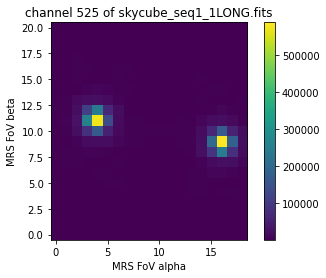

In [22]:
show_outputs(directory_list[2],'skycubes')

### Viewing an averaged spectrum over the full MRS FOV for each disperser and channel of the input scene to the MRS simulation

For the full MRS spectral range a total of **12** **<code>skycubes</code>** are generated by MIRISim- four per disperser. NOTE: These cubes have not been processed by MIRISim. 
Below, we show an average spectum for the input scene across the MRS FOV for each of the 12 **<code>skycubes</code>**. The wavelength ranges of each skycube is also printed. 

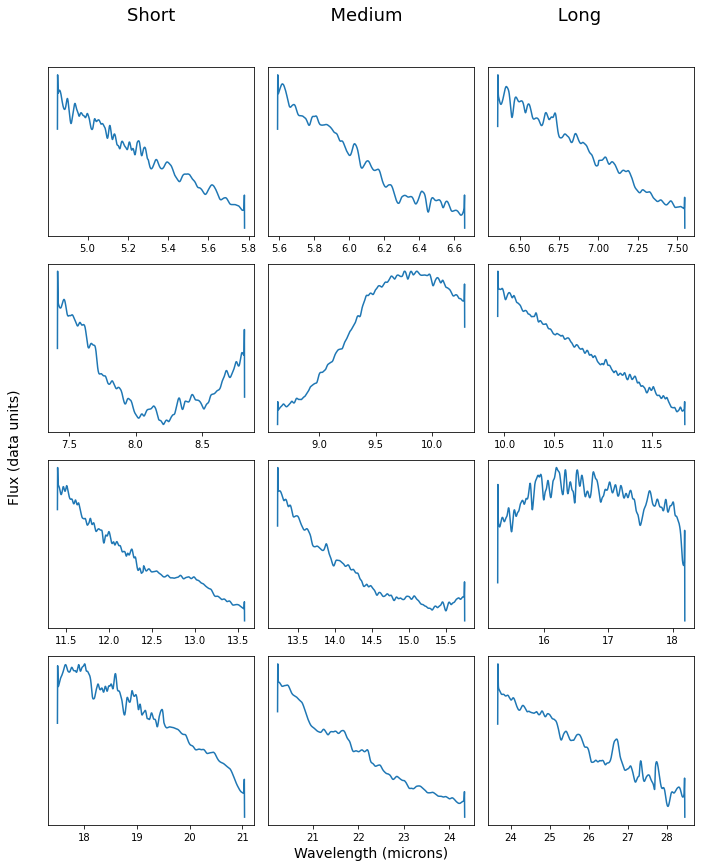

In [23]:
show_skycubes_spec(directory_list)  

## The outputs of MIRISim can now be run through the JWST pipeline see:
###  https://jwst-docs.stsci.edu/jwst-data-reduction-pipeline and https://jwst-pipeline.readthedocs.io/en/stable/

## About this notebook
**Author:** Olivia Jones, Project Scientist, UK ATC. 
**Updated On:** 2020-08-20

***

[Top of Page](#top)